<a href="https://colab.research.google.com/github/PaulToronto/Applied-Geospatial-Data-Science-with-Python---Book/blob/main/2_4_Contextily_Working_With_Local_Files.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contextily Working With Local Files

## Imports

In [1]:
!pip install contextily

In [2]:
import contextily as cx
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.plot import show as rioshow
from shapely.geometry import box

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

drive_path = '/content/gdrive/MyDrive/Colab Notebooks/Data Science/Applied Geospatial Data Science with Python - Book/data/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## CLIWOC Data

- https://blogs.loc.gov/maps/2023/04/new-interactive-map-visualizes-ship-logbooks-from-the-18th-and-19th-centuries/

- https://figshare.com/articles/dataset/CLIWOC_Slim_and_Routes/11941224

In [4]:
#cliwoc = gpd.read_file('https://ndownloader.figshare.com/files/21940242')
cliwoc = gpd.read_file(drive_path + 'cliwoc_routes.gpkg')
cliwoc

ID       start         end  records  C1  length_days  \
0        1   1827-8-16  1827-11-13       90  NL           89   
1        2   1807-2-24    1807-4-4       40  UK           39   
2        3    1809-7-4   1809-8-14       42  UK           41   
3        4  1763-11-28   1767-4-12       28  UK         1231   
4        5    1774-5-5  1777-10-23      185  UK         1267   
...    ...         ...         ...      ...  ..          ...   
1968  2003  1823-11-16   1824-1-23       60  NL           68   
1969  2004   1833-6-26   1833-9-11       73  NL           77   
1970  2005   1841-6-28   1842-1-30       68  NL          216   
1971  2006   1845-12-5   1846-4-15      101  NL          131   
1972  2007    1842-1-2   1842-4-29      104  NL          117   

                                               geometry  
0     LINESTRING (103.10000 -6.92000, 100.47000 -8.2...  
1     LINESTRING (-8.38000 51.38000, -8.02000 51.080...  
2     LINESTRING (-65.35000 19.65000, -65.30000 20.5...  
3     LINESTRING (-16.15000 32.32000, -15.50000 31.9...  
4     LINESTRING (-66.70000 41.65000, -63.93000 41.2...  
...                                                 ...  
1968  LINESTRING (-68.52000 12.13000, -68.23000 14.5...  
1969  LINESTRING (0.97000 50.87000, -0.02000 50.5400...  
1970  LINESTRING (-8.01000 46.37000, -8.19000 45.410...  
1971  LINESTRING (103.88000 -7.15000, 102.17000 -8.6...  
1972  LINESTRING (-5.42000 49.42000, -7.00000 48.280...  

[1973 rows x 7 columns]

In [5]:
cliwoc.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
cliwoc = cliwoc.to_crs(epsg=3857)
cliwoc.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
cliwoc['start']

0        1827-8-16
1        1807-2-24
2         1809-7-4
3       1763-11-28
4         1774-5-5
           ...    
1968    1823-11-16
1969     1833-6-26
1970     1841-6-28
1971     1845-12-5
1972      1842-1-2
Name: start, Length: 1973, dtype: object

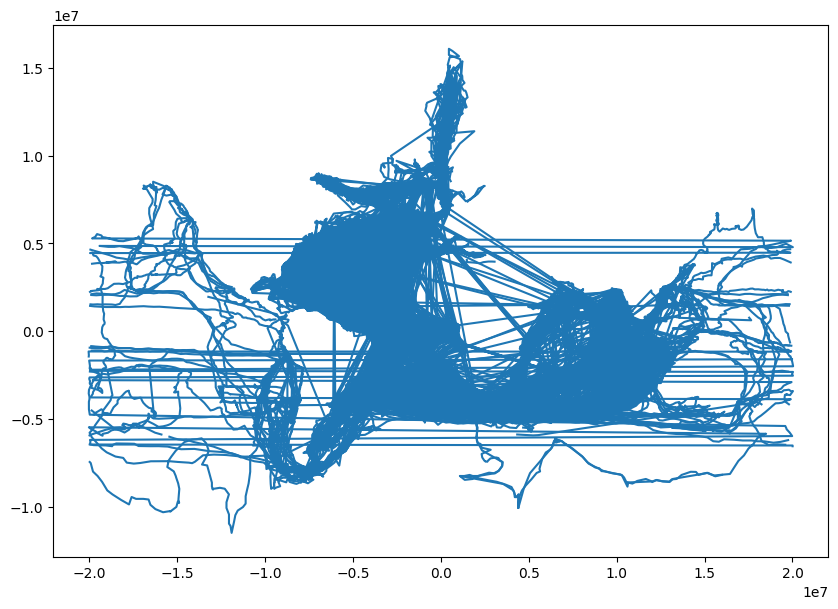

In [8]:
cliwoc.plot(figsize=(10, 10));

In [9]:
begin = pd.to_datetime(cliwoc['start'], errors='coerce').min().year
end = pd.to_datetime(cliwoc['start'], errors='coerce').max().year
begin, end

(1699, 1854)

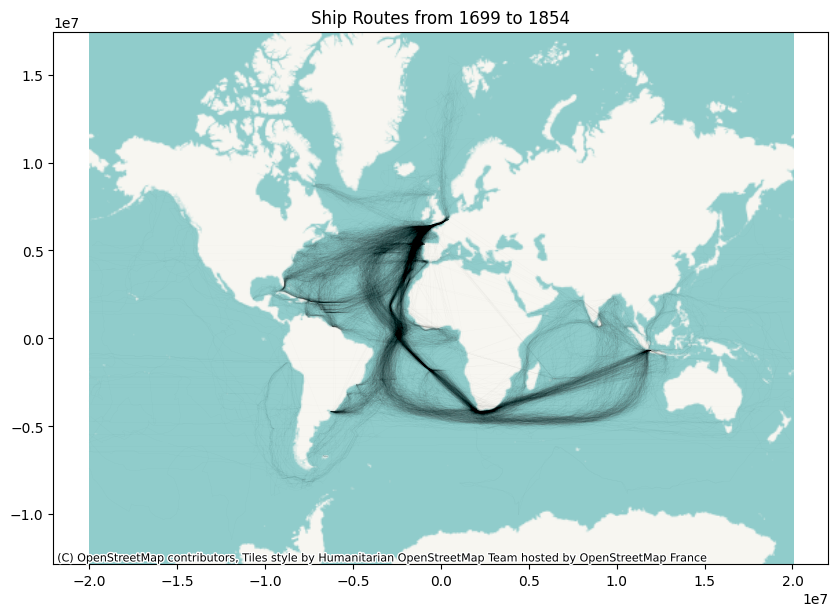

In [10]:
ax = cliwoc.plot(linewidth=0.01,
                 alpha=0.5,
                 color='k',
                 figsize=(10, 10))
ax.set_title(f'Ship Routes from {begin} to {end}')
cx.add_basemap(ax=ax)

## Raster from bounds

- `bounds2raster`
    - expects a bounding box
    - dowloads a basemap as a `.tif` file

In [11]:
# minX, minY, maxX, maxY
cliwoc.total_bounds

array([-20035281.95297338, -11460651.17387515,  20035281.95297338,
        16073025.50637364])

In [12]:
img, ext = cx.bounds2raster(*cliwoc.total_bounds,
                            drive_path + 'world.tif')

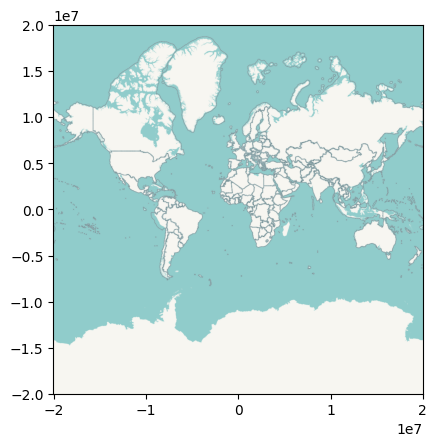

In [13]:
with rio.open(drive_path + 'world.tif') as r:
    rioshow(r)

- Note that the basemap is alawys stored in it's orginal CRS

## Raster from name

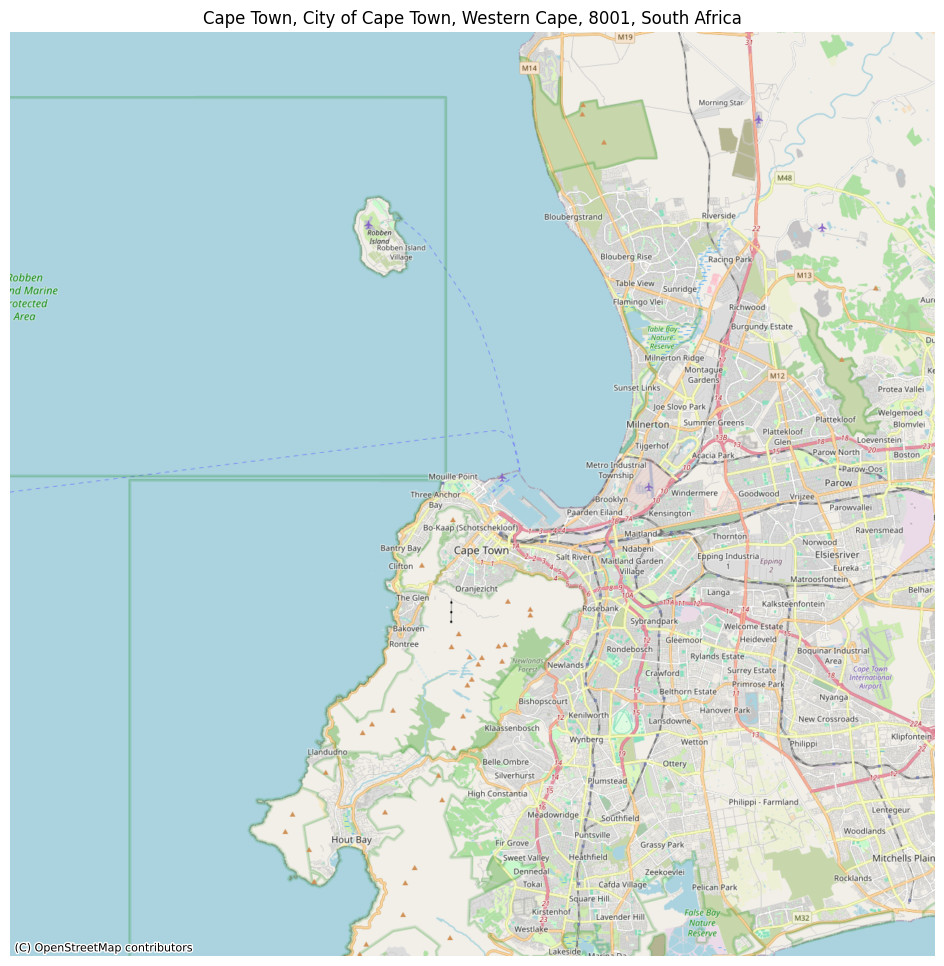

In [14]:
cape_town = cx.Place('Cape Town',
                     source=cx.providers.OpenStreetMap.Mapnik)

cape_town.plot();

- If we want to save it, we simply use the `path` arugment

In [15]:
cape_town2 = cx.Place('Cape Town',
                      source=cx.providers.OpenStreetMap.Mapnik,
                      path=drive_path + 'cape_town.tif')

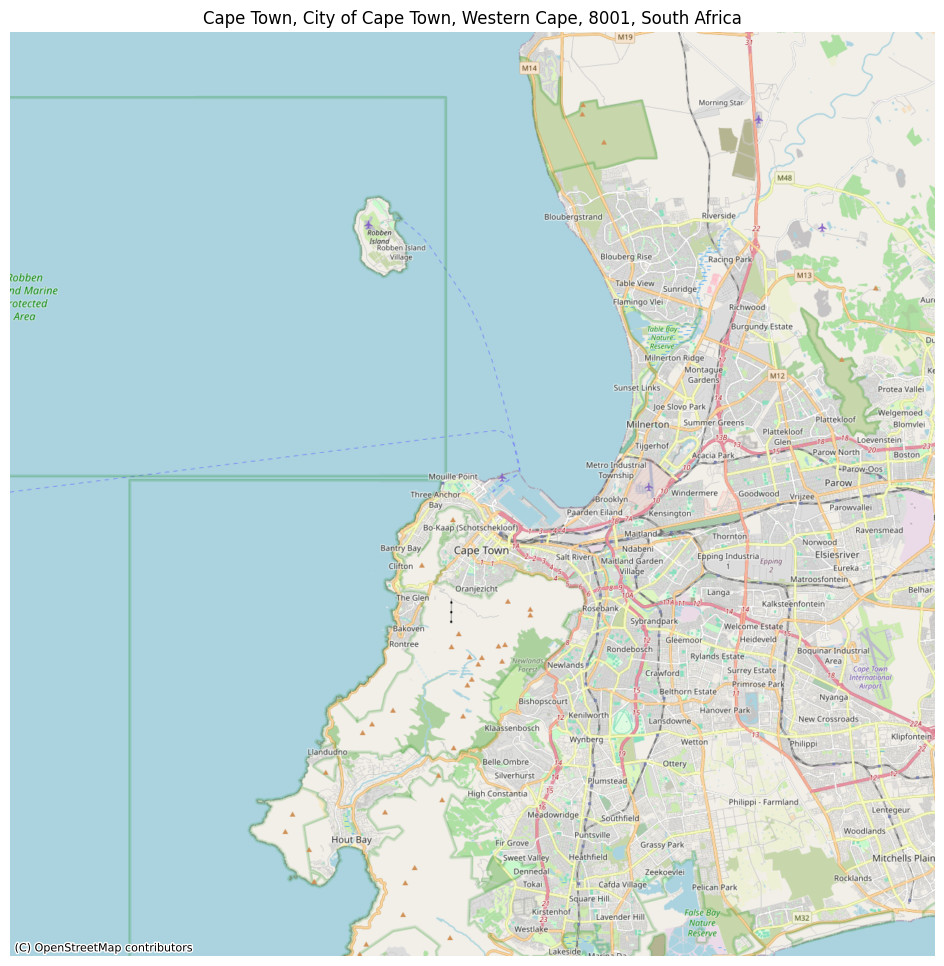

In [16]:
# still works
cape_town2.plot();

## Reading local rasters

Two ways:
1. with `rasterio`
2. with `add_basemap`

### Reading with `rasterio`

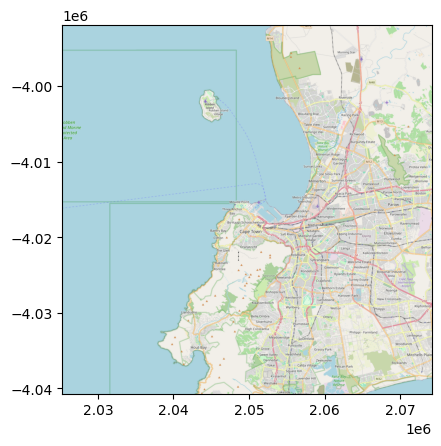

In [17]:
with rio.open(drive_path + 'cape_town.tif') as r:
    rioshow(r)

### Reading with `add_basemap`

- For demonstration purposes, we first clip out sections of the CLIWOC routes with the bounding box of Cape Town

In [18]:
with rio.open(drive_path + 'cape_town.tif') as r:
    print(r.bounds)
    left, bottom, right, top = tuple(r.bounds)
    cape_town_crs = r.crs

BoundingBox(left=2025256.3921869588, bottom=-4040747.9540104866, right=2074176.0902894714, top=-3991828.255907974)


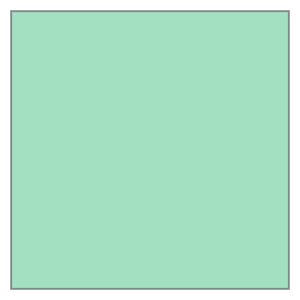

In [19]:
bb_poly = box(left, bottom, right, top)
bb_poly

In [20]:
type(bb_poly)

shapely.geometry.polygon.Polygon

In [21]:
print(bb_poly)

POLYGON ((2074176.0902894714 -4040747.9540104866, 2074176.0902894714 -3991828.255907974, 2025256.3921869588 -3991828.255907974, 2025256.3921869588 -4040747.9540104866, 2074176.0902894714 -4040747.9540104866))


In [22]:
bb_poly = gpd.GeoDataFrame({'geometry': [bb_poly]},
                           crs=cape_town_crs)

bb_poly

geometry
0  POLYGON ((2074176.090 -4040747.954, 2074176.09...

In [23]:
cliwoc

ID       start         end  records  C1  length_days  \
0        1   1827-8-16  1827-11-13       90  NL           89   
1        2   1807-2-24    1807-4-4       40  UK           39   
2        3    1809-7-4   1809-8-14       42  UK           41   
3        4  1763-11-28   1767-4-12       28  UK         1231   
4        5    1774-5-5  1777-10-23      185  UK         1267   
...    ...         ...         ...      ...  ..          ...   
1968  2003  1823-11-16   1824-1-23       60  NL           68   
1969  2004   1833-6-26   1833-9-11       73  NL           77   
1970  2005   1841-6-28   1842-1-30       68  NL          216   
1971  2006   1845-12-5   1846-4-15      101  NL          131   
1972  2007    1842-1-2   1842-4-29      104  NL          117   

                                               geometry  
0     LINESTRING (11477039.501 -772210.542, 11184269...  
1     LINESTRING (-932857.333 6688788.594, -892782.3...  
2     LINESTRING (-7274728.723 2231614.390, -7269162...  
3     LINESTRING (-1797809.776 3805389.287, -1725452...  
4     LINESTRING (-7425010.036 5108694.476, -7116655...  
...                                                 ...  
1968  LINESTRING (-7627611.509 1360506.826, -7595328...  
1969  LINESTRING (107979.906 6598330.364, -2226.390 ...  
1970  LINESTRING (-891669.121 5839841.534, -911706.6...  
1971  LINESTRING (11563868.704 -798008.260, 11373512...  
1972  LINESTRING (-603351.640 6346429.429, -779236.4...  

[1973 rows x 7 columns]

In [24]:
cliwoc_cape_town = gpd.overlay(cliwoc,
                               bb_poly.to_crs(cliwoc.crs),
                               how='intersection')

cliwoc_cape_town

ID      start         end  records  C1  length_days  \
0     28  1677-4-21   1677-9-23      129  NL          155   
1     37  1753-12-1   1757-2-17      373  NL         1174   
2     40  1798-6-29  1798-11-25      116  UK          149   
3     51  1796-9-17   1798-3-15      186  UK          544   
4     52  1833-6-27   1834-5-17      234  NL          324   
..   ...        ...         ...      ...  ..          ...   
68  1983  1790-10-2    1791-3-1      150  NL          150   
69  1991  1786-5-13  1786-11-16      152  NL          187   
70  2001  1841-7-23   1842-4-29       83  NL          280   
71  2006  1845-12-5   1846-4-15      101  NL          131   
72  2007   1842-1-2   1842-4-29      104  NL          117   

                                             geometry  
0   LINESTRING (2025256.392 -4032831.005, 2026014....  
1   LINESTRING (2074176.090 -4026449.271, 2046501....  
2   LINESTRING (2025256.392 -4010526.912, 2039373....  
3   LINESTRING (2070243.304 -4040747.954, 2046052....  
4   LINESTRING (2070037.738 -4040747.954, 2025256....  
..                                                ...  
68  MULTILINESTRING ((2025256.392 -4036788.960, 20...  
69  LINESTRING (2025256.392 -4038333.384, 2026014....  
70  LINESTRING (2025256.392 -4009803.227, 2033807....  
71  LINESTRING (2028659.172 -4040747.954, 2025256....  
72  LINESTRING (2025256.392 -4004192.572, 2033807....  

[73 rows x 7 columns]

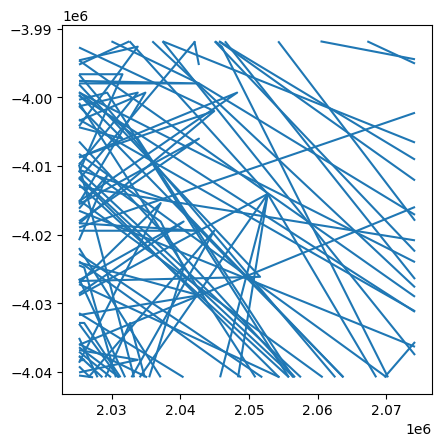

In [25]:
cliwoc_cape_town.plot();

- Also, clip routes within 10km of the centre of Cape Town

In [26]:
cape_town_buffer = gpd.GeoDataFrame({'geometry': bb_poly.centroid.buffer(10000)},
                                    crs=bb_poly.crs)
cape_town_buffer

geometry
0  POLYGON ((2059716.241 -4016288.105, 2059668.08...

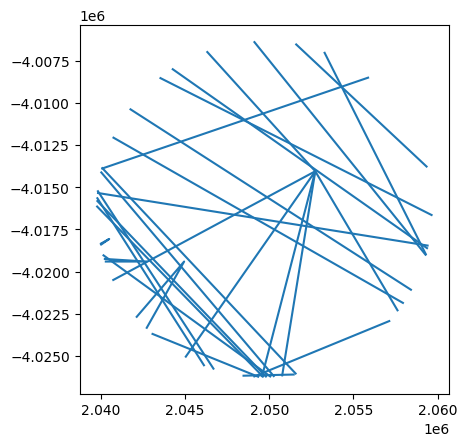

In [27]:
cliwoc_cape_town_buffer = gpd.overlay(cliwoc,
                                      cape_town_buffer.to_crs(cliwoc.crs))

cliwoc_cape_town_buffer.plot();

- Next we add a basemap

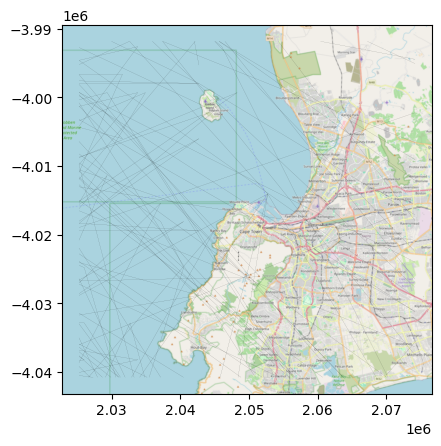

In [28]:
ax = cliwoc_cape_town.plot(linewidth=0.05, color='k')
cx.add_basemap(ax,
               crs=cliwoc_cape_town.crs,
               source=drive_path + 'cape_town.tif')

- Just as we can do with web tiles, we can "dim" the basemap with `alpha`

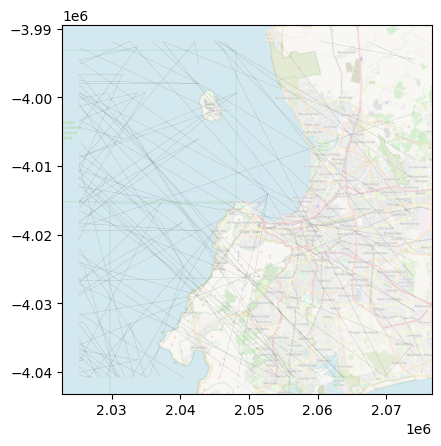

In [29]:
ax = cliwoc_cape_town.plot(linewidth=0.05, color='k')
cx.add_basemap(ax,
               crs=cliwoc_cape_town.crs,
               source=drive_path + 'cape_town.tif',
               alpha=0.5)

- the `add_basemap` method as the `reset_extent` parameter which is set to `True` by default

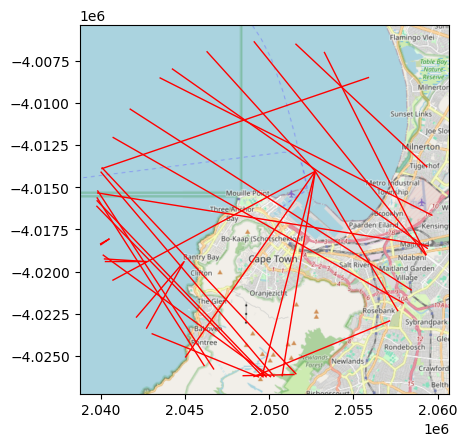

In [30]:
# let's keep it at True for now
ax = cliwoc_cape_town_buffer.plot(linewidth=1, color='r')
cx.add_basemap(ax,
               crs=cliwoc_cape_town_buffer.crs,
               source=drive_path + 'cape_town.tif')

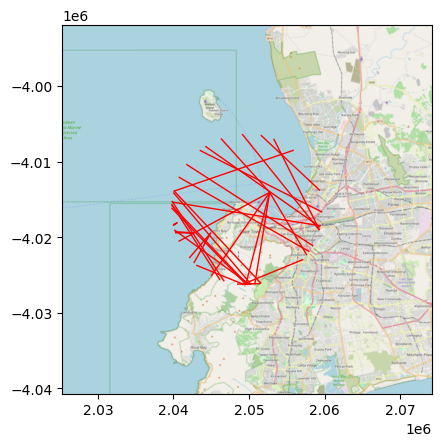

In [31]:
# see what happens when setting it to False
ax = cliwoc_cape_town_buffer.plot(linewidth=1, color='r')
cx.add_basemap(ax,
               crs=cliwoc_cape_town_buffer.crs,
               source=drive_path + 'cape_town.tif',
               reset_extent=False)